**Description**: Analyzes BERT *and* GPT-2 accuracies for a given number of test
observations (200 or 500). Currently just 2 chains. Need to increase that, but it's too
slow :-(

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

Note: I'm still learning how to do this type of analysis.

In [1]:
import os
from typing import Literal

import polars as pl
import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 500

# Load data

In [4]:
def load(accuracies_home_dir: str = "accuracies_from_paper", num_test: int = num_test):
    dfs: list[pl.DataFrame] = []
    for lm_type in utils.lm_type_to_name.keys():
        accuracies_dir = os.path.join(accuracies_home_dir, str(num_test), lm_type)
        df = utils.load_num_correct(accuracies_dir, num_test).with_columns(
            lm_type=pl.lit(lm_type)
        )
        df = df.select("lm_type").with_columns(df.select(pl.exclude("lm_type")))
        dfs.append(df)
    return pl.concat(dfs)

In [5]:
num_correct_df = load()

In [6]:
equation = "num_correct ~ method + lm_type + (1|dataset/pair)"
id_vars = ["pair", "lm_type", "dataset"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1389 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.095,0.003,0.09,0.102,0.0,0.0,3389.0,1189.0,1.0


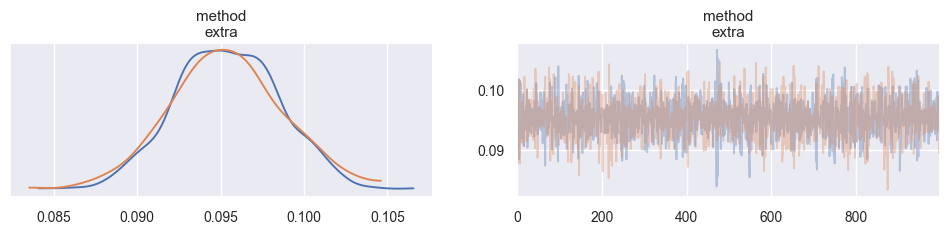

In [7]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df,
    treatment="extra",
    control="base",
    equation=equation,
    id_vars=id_vars,
    chains=2,
)

In [8]:
print(model_control)

       Formula: num_correct ~ method + lm_type + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.3301)
            method ~ Normal(mu: 0.0, sigma: 5.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.3301))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.3301))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1460 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.001,0.003,-0.007,0.005,0.0,0.0,3116.0,1387.0,1.0


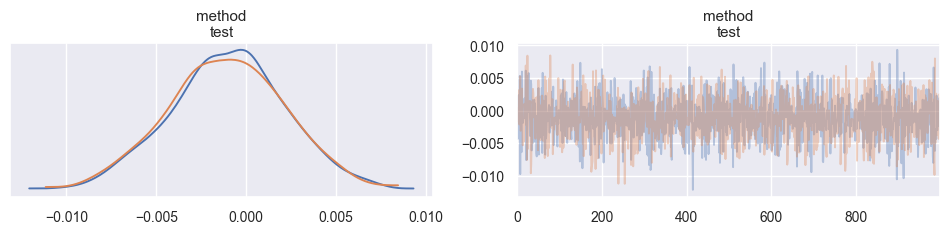

In [9]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df,
    treatment="test",
    control="extra",
    equation=equation,
    id_vars=id_vars,
    chains=2,
)

In [10]:
print(model_bias)

       Formula: num_correct ~ method + lm_type + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.3301)
            method ~ Normal(mu: 0.0, sigma: 5.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.3301))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.3301))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
